In [0]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .master("local[*]") \
    .appName("FinalCoursework") \
    .getOrCreate()

sc = spark.sparkContext

In [0]:
dir_path="/FileStore/data/archive"
# <FILL-IN WITH YOUR CODE>
df_trump = spark.read.option("multiline", True).csv(dir_path+"/hashtag_donaldtrump.csv", header=True, inferSchema=True)
df_biden = spark.read.option("multiline", True).csv(dir_path+"/hashtag_joebiden.csv", header=True, inferSchema=True)
# <FILL-IN WITH YOUR CODE>

In [0]:
def transer_data_type(data):
  data = data.withColumn("likes", data["likes"].cast("int"))
  data = data.withColumn("retweet_count", data["retweet_count"].cast("int"))
  data = data.withColumn("user_followers_count", data["user_followers_count"].cast("int"))
  data = data.withColumn("lat", data["lat"].cast("float"))
  data = data.withColumn("long", data["long"].cast("float"))
  return data

df_trump = transer_data_type(df_trump)
df_biden = transer_data_type(df_biden)

In [0]:
#Dropping columns
remove_columns = ['created_at', 'tweet_id', 'user_id', 'user_screen_name', 'user_join_date', 'collected_at', 'user_name', 'user_description', 'user_location', 'lat', 'long', 'city', 'country', 'continent', 'state', 'state_code']
df_trump = df_trump.drop(*remove_columns)
df_biden = df_biden.drop(*remove_columns)

#Dropping rows with na values
df_trump = df_trump.na.drop()
df_biden = df_biden.na.drop()

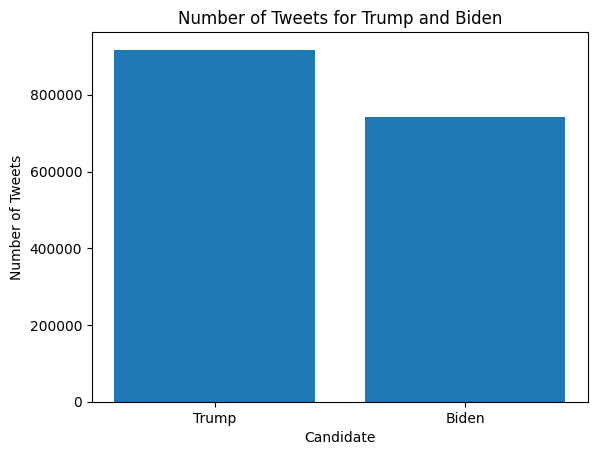

In [0]:
import matplotlib.pyplot as plt

# Create a bar plot
plt.bar(['Trump', 'Biden'], [df_trump.count(), df_biden.count()])
plt.xlabel('Candidate')
plt.ylabel('Number of Tweets')
plt.title('Number of Tweets for Trump and Biden')
plt.show()

In [0]:
from pyspark.sql.functions import lit
#创建一个新列，0表示特朗普，1表示拜登
#Adding a presidents column where 0 represents trump and 1 represents biden. This will turn it into a classification problem
df_trump = df_trump.withColumn('President', lit(0))
df_biden = df_biden.withColumn('President', lit(1))

#Merging the 2 datasets
#上下堆集起来
df = df_trump.union(df_biden)

In [0]:
df.show(5)

+--------------------+-----+-------------+------------------+--------------------+---------+
|               tweet|likes|retweet_count|            source|user_followers_count|President|
+--------------------+-----+-------------+------------------+--------------------+---------+
|#Elecciones2020 |...|    0|            0|         TweetDeck|                1860|        0|
|Usa 2020, Trump c...|   26|            9|  Social Mediaset |             1067661|        0|
|#Trump: As a stud...|    2|            1|   Twitter Web App|                1185|        0|
|2 hours since las...|    0|            0|     Trumpytweeter|                  32|        0|
|You get a tie! An...|    4|            3|Twitter for iPhone|                5393|        0|
+--------------------+-----+-------------+------------------+--------------------+---------+
only showing top 5 rows



In [0]:
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StringType
from collections import Counter
import re

#Extracts all the hastags from the tweet and stores them in a list
@udf(returnType=ArrayType(StringType()))
def getHashtagList(tweet):
  tweet = tweet.lower()
  tweet = re.sub(r'[^\w\s#]', '', tweet)
  hashtag_list = []

  for word in tweet.split():
    if word[0] == '#':
      hashtag_list.append(word)
  
  #Creates a dictionary where the hashtags are the key and their frequency in the list is the value
  count_hashtags = Counter(hashtag_list)

  #Remove duplicate hashtags
  unique_hashtags = [hashtag for hashtag, frequency in count_hashtags.items() if frequency == 1]

  return hashtag_list

#Creates a column called hashtags which stores a hastag list for all the tweets
df = df.withColumn('hashtags', getHashtagList(df['tweet']))

In [0]:
from pyspark.sql import functions as F
    
#Splits the hashtag list and displays each hashtag in its own row in column hashtag
df_exploded = df.withColumn('hashtag', F.explode(df['hashtags']))

#Creates a new column called count which displays how many rows the hashtag appears in
#The counts will be used in TF-IDF calculation
df_count = df_exploded.groupBy("hashtag").count()

#Renaming count to hashtag_count
df_count = df_count.withColumnRenamed('count', 'hashtag_count')

#Joining df_count with df_exploded on hashtag
df_exploded = df_exploded.join(df_count, on="hashtag", how="left")

# Group by original columns and collect list of counts
df = df_exploded.groupBy(df.columns).agg(F.collect_list("hashtag_count").alias("hashtag_counts"))

In [0]:
df_count = df.count()
print(df_count)

1643761


In [0]:
from pyspark.sql.types import FloatType
import math

#Creates the TF_IDF list column
@udf(returnType=FloatType())
def getAvg_TF_IDF(hashtags, hashtag_counts, df_count):
  avg_TF_IDF = 0
  count = 0

  #If there are no hashtags the tweet will be given a value of 0
  if len(hashtags) == 0:
    return 0.0

  for hashtag in hashtags:
    #Calculating TF
    #Since all the hastags are unique 1 is being divided by the total number of hastags
    TF = 1 / len(hashtags)
    #nDocs is the number of rows/tweets the hastag is used
    nDocs = hashtag_counts[count]
    #Calculating IDF
    #df_count is the total number of rows/tweets
    IDF = math.log(df_count / nDocs)
    TF_IDF = TF * IDF
    avg_TF_IDF += TF_IDF
    count += 1

  avg_TF_IDF /= count
  return avg_TF_IDF

# Apply the UDF to your DataFrame
df = df.withColumn('TF_IDF', getAvg_TF_IDF(df['hashtags'], df['hashtag_counts'], lit(df_count)))

In [0]:
from pyspark.sql.types import FloatType
import math

#Creates the TF_IDF list column
@udf(returnType=ArrayType(FloatType()))
def getAvg_TF_IDF(hashtags, hashtag_counts, df_count):
  TF_IDF_list = []
  count = 0

  #If there are no hashtags the tweet will be given a value of 0
  if len(hashtags) == 0:
    return 0.0

  for hashtag in hashtags:
    #Calculating TF
    #Since all the hastags are unique 1 is being divided by the total number of hastags
    TF = 1 / len(hashtags)
    #nDocs is the number of rows/tweets the hastag is used
    nDocs = hashtag_counts[count]
    #Calculating IDF
    #df_count is the total number of rows/tweets
    IDF = math.log(df_count / nDocs)
    TF_IDF = TF * IDF
    TF_IDF_list.append(TF_IDF)
    count += 1

  return TF_IDF_list

# Apply the UDF to your DataFrame
df = df.withColumn('TF_IDF_list', getAvg_TF_IDF(df['hashtags'], df['hashtag_counts'], lit(df_count)))

In [0]:
import re,string
# This code defines a function named "tokenize" that tokenizes the input text.
# It removes special characters, converts the text to lowercase, and removes stopwords and punctuation.
# The resulting tokens are added to a list and returned.
#在文本处理过程中，移除这些停用词可以帮助减少文本数据的噪音，并且有助于集中注意力在那些真正包含有意义信息的词语上。
# This code defines a list of stopwords to be removed from the text.
stopwords = [u'rt', u're', u'i', u'me', u'my', u'myself', u'we', u'our', u'ours', u'ourselves', u'you', u'your',
             u'yours', u'yourself', u'yourselves', u'he', u'him', u'his', u'himself', u'she', u'her', u'hers',
             u'herself', u'it', u'its', u'itself', u'they', u'them', u'their', u'theirs', u'themselves', u'what',
             u'which', u'who', u'whom', u'this', u'that', u'these', u'those', u'am', u'is', u'are', u'was', u'were',
             u'be', u'been', u'being', u'have', u'has', u'had', u'having', u'do', u'does', u'did', u'doing', u'a',
             u'an', u'the', u'and', u'but', u'if', u'or', u'because', u'as', u'until', u'while', u'of', u'at', u'by',
             u'for', u'with', u'about', u'against', u'between', u'into', u'through', u'during', u'before', u'after',
             u'above', u'below', u'to', u'from', u'up', u'down', u'in', u'out', u'on', u'off', u'over', u'under',
             u'again', u'further', u'then', u'once', u'here', u'there', u'when', u'where', u'why', u'how', u'all',
             u'any', u'both', u'each', u'few', u'more', u'most', u'other', u'some', u'such', u'no', u'nor', u'not',
             u'only', u'own', u'same', u'so', u'than', u'too', u'very', u's', u't', u'can', u'will', u'just', u'don',
             u'should', u'now']
#经过处理后的单词列表
def tokenize(text):
    # Remove URLs
    text = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*(),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text)
    
    # Remove special characters
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
    
    # Convert text to lowercase
    text = text.lower()
    
    # Split text into tokens and filter out stopwords, single characters, and '``'
    tokens = [word for word in text.split() if word not in stopwords and len(word) > 1 and word != '``']
    
    return tokens

In [0]:
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StringType,IntegerType

#将一个Python函数转换为可在Spark DataFrame中使用的UDF
#UDF接受一个文本输入，并返回一个字符串类型的数组
# Define UDF to tokenize the tweet attribute
@udf(returnType=ArrayType(StringType()))
def tokenize_tweet(text):
    # Write code here to tokenize the tweet using the desired method/function
    tokens = tokenize(text)
    return tokens

# Add a new column 'Tokens' to the DataFrame 'df' by calling the 'tokenize_tweet' UDF on the 'tweet' column
df=df.withColumn('Tokens', tokenize_tweet(df['tweet']))

In [0]:
df.show(3)

+--------------------+-----+-------------+-------------------+--------------------+---------+--------+--------------+---------+-----------+--------------------+
|               tweet|likes|retweet_count|             source|user_followers_count|President|hashtags|hashtag_counts|   TF_IDF|TF_IDF_list|              Tokens|
+--------------------+-----+-------------+-------------------+--------------------+---------+--------+--------------+---------+-----------+--------------------+
| He’s nothing mor...|    0|            0|    Twitter Web App|                  71|        0|[#trump]|      [968674]|0.5288141|[0.5288141]|[he’s, nothing, p...|
| it shows that #t...|    1|            0|Twitter for Android|                  11|        0|[#trump]|      [968674]|0.5288141|[0.5288141]|[shows, trump, ca...|
| media-sourced po...|    0|            0|Twitter for Android|                 657|        0|[#biden]|      [631862]|0.9560712|[0.9560712]|[media, sourced, ...|
+--------------------+-----+------

In [0]:
from pyspark import SQLContext
sqlContext = SQLContext(sc)
#Parquet文件通常用于高效地存储数据，使用alias()方法为读取的数据集设置了一个别名lookup
lookup = sqlContext.read.parquet("/FileStore/word2vecM_simple/data").alias("lookup")
#打印了lookup数据集的模式（schema）
lookup.printSchema()
#将lookup数据集转换为RDD，并将其收集到驱动程序节点上的字典中
#将RDD中的所有数据收集到一个Python字典中，并且这个字典将存储在驱动程序节点的内存中，以便可以在驱动程序节点上进行快速的本地访问。
lookup_bd = sc.broadcast(lookup.rdd.collectAsMap())

/databricks/spark/python/pyspark/sql/context.py:117: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


root
 |-- word: string (nullable = true)
 |-- vector: array (nullable = true)
 |    |-- element: float (containsNull = true)



In [0]:
# Change the return type of the function from ndarray to list
#将文档转换为其向量表示（通常称为doc2vec），方法是将文档中每个单词的词向量进行求和并取平均
def doc2vec(document):
    doc_vec = [0.0] * 100
    tot_words = 0
    
    for word in document:
        try:
            #lookup_bd是上面定义的广播，获取到的词向量
            vec = lookup_bd.value.get(word)
            if vec is not None:
                #如果词向量存在就相加
                doc_vec = [a + b + 1 for a, b in zip(doc_vec, vec)]
                tot_words += 1
        except:
            continue
    
    if tot_words > 0:
        doc_vec = [a / float(tot_words) for a in doc_vec]
    #返回平均值
    return doc_vec

In [0]:
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StringType,FloatType

# Define UDF to calculate the vector representation of the document by summing up the feature values of each word in the document
#指定了该UDF的返回类型为一个浮点数数组。
@udf(returnType=ArrayType(FloatType()))
def doc_to_vec(tokens):
    #这一行调用了之前定义的tokenize函数，将文档的原始文本转换为单词列表。
    token=tokenize(tokens)
    # Write code here to calculate the vector representation of the document using the desired method/function
    #这一行调用了之前定义的doc2vec函数，将单词列表转换为文档向量。
    vector = doc2vec(token)
    return vector
  
# Add a new column 'DocVec' to the DataFrame 'df' by calling the 'doc_to_vec' UDF on the 'Tokens' column
df=df.withColumn('DocVec', doc_to_vec(df['tweet']))

In [0]:
df.select("DocVec").show(5)

+--------------------+
|              DocVec|
+--------------------+
|[0.9482574, 1.005...|
|[1.030534, 1.0578...|
|[1.0928096, 1.130...|
|[1.0245805, 1.036...|
|[0.0, 0.0, 0.0, 0...|
+--------------------+
only showing top 5 rows



In [0]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer
#创建情感分析的实例对象
sia = SentimentIntensityAnalyzer()
#然后将这个实例对象广播到每个节点
sc.broadcast(sia)

def calculate_sentiment(text):
    #sia = SentimentIntensityAnalyzer()
    #检查对象类型是不是list，如果就将这个text转化到string类型
    if isinstance(text, list):
        text = ' '.join(text)
    sentiment_scores = sia.polarity_scores(text)['compound']

    '''if(sentiment_scores>0):
      sentiment_scores=1
    elif(sentiment_scores<0):
      sentiment_scores=-1
    else:
      sentiment_scores=0'''
    return sentiment_scores

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/spark-26edbb81-9a36-4c83-b8a9-26/nltk_data...


In [0]:
from pyspark.sql.types import *

# Define UDF to tokenize the tweet attribute

@udf(returnType=FloatType())
def tokenize_tweet(text):
    # Write code here to tokenize the tweet using the desired method/function
    #表示每条推文的文本内容。
    tokens = tokenize(text)
    #计算了每条推文的情感极性分数
    sent=calculate_sentiment(tokens)
    return sent

# Add a new column 'Tokens' to the DataFrame 'df' by calling the 'tokenize_tweet' UDF on the 'tweet' column
#polarity就是每个tweet的情感分析的值
df=df.withColumn('polarity', tokenize_tweet(df['tweet']))


In [0]:
df.select("polarity").show(3)

+--------+
|polarity|
+--------+
|     0.0|
|  0.3612|
|     0.0|
+--------+
only showing top 3 rows



In [0]:
from pyspark.sql.functions import when, col

df = df.withColumn('sent', when(col('polarity') > 0, 1)
                        .when(col('polarity') <= 0, -1)
                        .otherwise(0))

In [0]:
df.show(10)

+--------------------+-----+-------------+-------------------+--------------------+---------+--------------------+--------------------+----------+--------------------+--------------------+--------------------+--------+----+
|               tweet|likes|retweet_count|             source|user_followers_count|President|            hashtags|      hashtag_counts|    TF_IDF|         TF_IDF_list|              Tokens|              DocVec|polarity|sent|
+--------------------+-----+-------------+-------------------+--------------------+---------+--------------------+--------------------+----------+--------------------+--------------------+--------------------+--------+----+
| He’s nothing mor...|    0|            0|    Twitter Web App|                  71|        0|            [#trump]|            [968674]| 0.5288141|         [0.5288141]|[he’s, nothing, p...|[1.0475026, 1.029...|  0.0772|   1|
| it shows that #t...|    1|            0|Twitter for Android|                  11|        0|           

In [0]:
seed = 303
train_df, test_df = df.randomSplit([0.7, 0.3], seed=seed)

train_df.cache()
test_df.cache()

print("Number of rows in training set:", train_df.count())
print("Number of rows in test set:", test_df.count())

Number of rows in training set: 1150745
Number of rows in test set: 493016


In [0]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("DT Pipeline") \
    .getOrCreate()

In [0]:
from pyspark.sql.types import FloatType
import math

#Creates the TF_IDF list column
@udf(returnType=FloatType())
def getAvg_TF_IDF(hashtags, hashtag_counts, df_count):
  avg_TF_IDF = 0
  count = 0

  #If there are no hashtags the tweet will be given a value of 0
  if len(hashtags) == 0:
    return 0.0

  for hashtag in hashtags:
    #Calculating TF
    #Since all the hastags are unique 1 is being divided by the total number of hastags
    TF = 1 / len(hashtags)
    #nDocs is the number of rows/tweets the hastag is used
    nDocs = hashtag_counts[count]
    #Calculating IDF
    #df_count is the total number of rows/tweets
    IDF = math.log(df_count / nDocs)
    TF_IDF = TF * IDF
    avg_TF_IDF += TF_IDF
    count += 1

  avg_TF_IDF /= count
  return avg_TF_IDF

# Apply the UDF to your DataFrame
df = df.withColumn('TF_IDF', getAvg_TF_IDF(df['hashtags'], df['hashtag_counts'], lit(df_count)))

In [0]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.sql.functions import col
feature_columns = ['likes', 'retweet_count', 'user_followers_count', 'sent', 'TF_IDF']
feature_assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')
rf_classifier = RandomForestClassifier(featuresCol='features', labelCol='President', numTrees=10)
pipeline = Pipeline(stages=[feature_assembler, rf_classifier])
pipeline_model = pipeline.fit(train_df)
predictions = pipeline_model.transform(test_df)
predictions.select('President', 'prediction').show()
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(labelCol='President', predictionCol='prediction', metricName='accuracy')
accuracy = evaluator.evaluate(predictions)
print("Accuracy:", accuracy)

+---------+----------+
|President|prediction|
+---------+----------+
|        1|       0.0|
|        0|       0.0|
|        1|       1.0|
|        0|       1.0|
|        0|       1.0|
|        1|       1.0|
|        0|       0.0|
|        1|       1.0|
|        1|       1.0|
|        1|       0.0|
|        1|       0.0|
|        0|       0.0|
|        0|       0.0|
|        0|       0.0|
|        0|       1.0|
|        0|       0.0|
|        1|       0.0|
|        1|       0.0|
|        1|       1.0|
|        0|       0.0|
+---------+----------+
only showing top 20 rows

Accuracy: 0.627665227903354
